***
# HCI Week 8 - Principal Component Analysis
*Matthew Kenworthy // Leiden Observatory*
***
Today we cover the implementation of Principal Component Analysis as described in [Amara and Quanz (2012)](http://adsabs.harvard.edu/abs/2012MNRAS.427..948A). Go and read Section 3.1.

## Principle Component Analysis

PCA is 'shift, scale, rotate'. The `first principal component` is the direction in which the transformed data has **MAXIMUM** variance. The second and higher components are *orthogonal to the first principal component*.

Any single science image can be thought of as a Iinear combination of an orthogonal basis set formed from all the science images. We can write this as:

$$
I(\vec{x})=\sum a_{i} \phi_{i}(\vec{x})
$$

where $I(\vec{x})$ is the image of the PSF, $\phi(\vec{x})$ is a given basis and $a_{i}$ is the coefficient for each basis function.

Instead of small wedges, the whole stack of images is taken and a **Principal Component Analysis** (PCA) is performed on it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)

def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot.
                """
    from scipy.ndimage import affine_transform
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output

    # determine centre of input image

    # -0.5 is there for fencepost counting error
    c_in = np.array(offset1) - 0.5
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def derot_cube(imin, rotangle, out_dims, star_cen):
    """derot_cube - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot degrees.
                """
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    # for every frame in imin perform the derotation of rotangle
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)    

## Data of the planetary system HR 8799

The data is from the [NIRC2](https://www2.keck.hawaii.edu/inst/nirc2/) camera on the Keck II 10m telescope, from observing program U159N2 by Bruce Macintosh. This data is courtesy of Travis Barman. Image registration by Raphael Galicher. 

The data is taken in the L prime (Lp) filter (covers 3.42 to 4.12 microns in wavelength), in the narrow camera pixel scale (10mas/pixel)

https://www2.keck.hawaii.edu/inst/nirc2/genspecs.html

## Image data and position angle data
The data is approximately 100 images taken over the course of one night on Keck in 2009. Keck is an Alt-az telescope, so the sky rotates in the camera field of view. To derotate the images so that they are all aligned on the sky, you need a list of derotation angles, provided in `rotnth.fits`. You can read it in the same way as the data cube file.

To save storage space, this cube is a cropped version of the data from the earlier Practicum. The sky background is **already subtracted** from this data set, so you do not need to do it again.


In [2]:
# read in the data cube
im, he = fits.getdata('im_pca.fits.gz', header=True)

# read in the rotation angles
rot = fits.getdata('rotnth.fits')


## Performing regular ADI

First, we will perform a regular ADI reduction, but this time using an annular mask (Question 8.1) and [numpy Broadcasting](https://numpy.org/devdocs/user/theory.broadcasting.html) to pull out the required pixels from the data cube (Question 8.2).

### Defining an annulus

Assume that the star is in the centre of each image frame.


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.1</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

1.  **Use `r_theta` to make a mask `m` that has the same dimensions as a single image frame, with inner radius of 10 pixels and outer radius of 120 pixels. Display this image with `ax.imshow()`.**
* **Print out the numer of pixels in the annular region and print out the shape of mask `m`.**

***



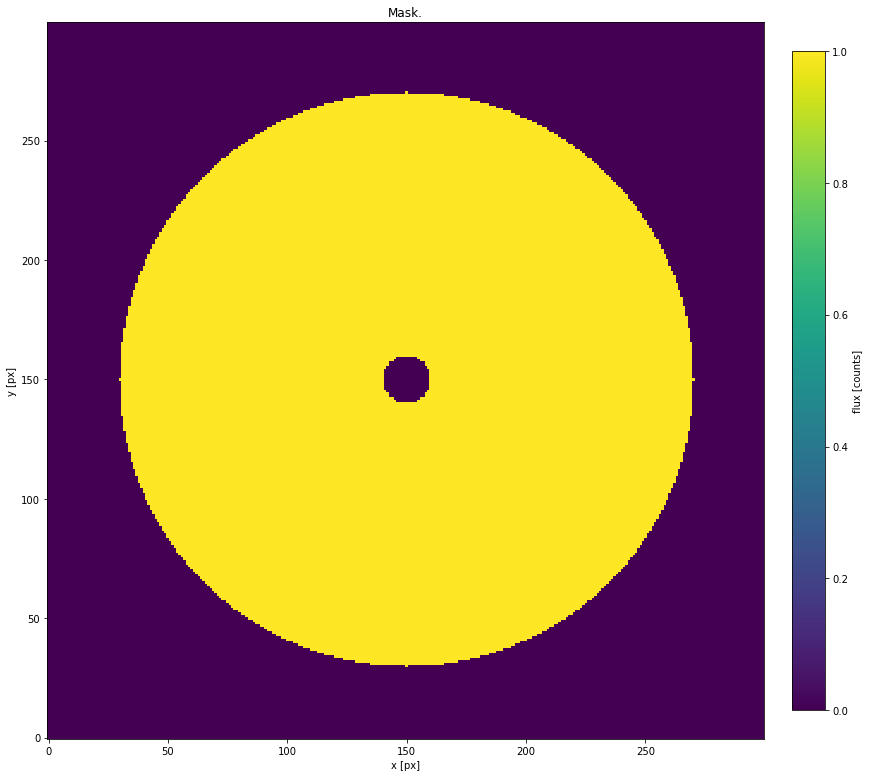

Number of pixels in annular region is 44920
The shape of the mask is (300, 300)


In [3]:
# Q1 answer here

xcen = im[0].shape[0] / 2.
ycen = im[0].shape[1] / 2.

rr, phi = r_theta(im[0], xcen, ycen)
# are the pixels inclusive or exclusive?
# I never really thought about this before, but here it produces a different output of course
# if its exclusive, uncomment the bottom line
mask = (rr>=10.) * (rr<=120.)
# mask = (rr>10.) * (rr<120.)


fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(mask)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Mask.') 

# ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
# fig.suptitle('HR 8799 - U159N2:\n- Deroated image (Img #0) -', fontsize=18, weight="bold")
plt.show()

# Q1 end of answer

print('Number of pixels in annular region is {}'.format(np.sum(mask)))
print('The shape of the mask is {}'.format(np.shape(mask)))

## Using broadcasting to select annular regions through the whole data cube

You've used broadcasting during this course to select columns and lines through data cubes and to generate functions. You can also use 2D masks to select data from a 3D data cube.


<div class="alert alert-block alert-info">
<b>The Broadcasting Rule: </b> <br>In order to broadcast, the size of the trailing axes for both arrays in an operation must either be the same size, or one of them must be one. <a href="https://numpy.org/devdocs/user/theory.broadcasting.html"> Explanation</a></div>


You can use a mask to select pixels from a 2D image like so - in this case, we are looking at frame 5 in the image cube `im`:
    
    ann_pix = im[5,:][m]
    print ann_pix
    (44928,)
   
Notice that the mask selection has flattened the output array into a 1D numpy vector.


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.2</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

If your data cube has a shape of `[X,Y,N]` and your mask has a shape of `[X,Y]`, then `image[mask]` will broadcast across `N` to output a 2D array containing `N` columns with `1D` vectors.

The dimensions of `im` are in the wrong order, though. We need to reorder them!

1. **Use `np.swapaxes()` to rearrange the order of dimensions in `im`.**
2. **Use the annulus mask to pull out all annulus pixels in the data cube into an array `A`.**
3. **Print the shape of `A`.**


<div class="alert alert-block alert-info">
<b>Tip: </b> Using <code>print(x.shape)</code> a lot will help you understand what's going on. </div>


***

In [4]:
print("The shape of the image im is:     {}".format(im.shape))

# Q2 answer here

im_new = np.swapaxes(im, 0, 2)
A = im_new[mask]

# Q2 end of answer

print("The shape of the array A is:      {}".format(A.shape))

The shape of the image im is:     (94, 300, 300)
The shape of the array A is:      (44920, 94)


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.3</span> <span style="  font-size:1em; color: SteelBlue;"> (2 point): </span>

1. **Calculate the median annulus of all the annuli combined and subtract it off all the individual annuli. (This is the equivalent of calculating the median image of the cube, and then subtracting this off all the individual frames in the cube.) Call it `Amedsub`.**


<div class="alert alert-block alert-info">
<b>Note: </b> You should NOT use a <code>for</code> loop to do this, only do it using broadcasting! Ask us if you are still unsure how to do this. </div>

* **Put `Amedsub` back into an empty data cube and derotate the image frames into 300x300 pixel images.  They should be aligned with the sky. Then take the median of this image stack. Call the new array `ADImed`. Use `ax.imshow(ADImed)` to plot the colorbar from a range of -500 to +500 counts.**


<div class="alert alert-block alert-info">
<b>Note 1: </b> After you have put <code>Amedsub</code> into the data cube, you will need to rearrange the axes back when you do the derotation of the image frames! <br>
<b>Note 2: </b> You should see three planets, with the innermost one showing lots of speckle noise next to it.</div>


***

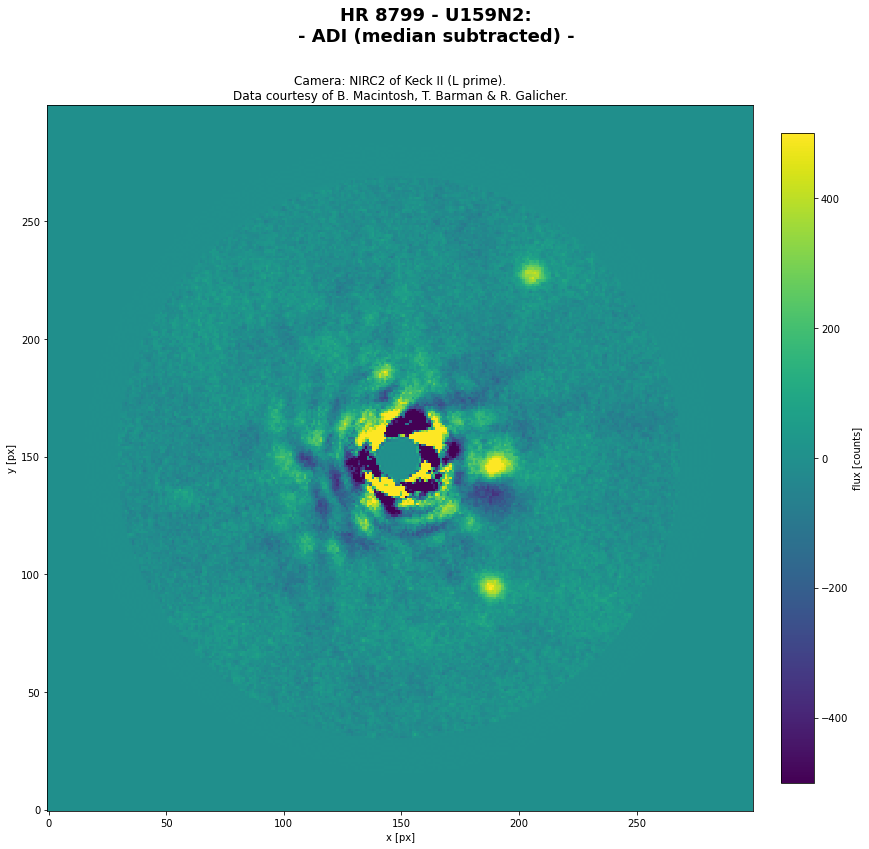

In [5]:
# Q3 answer here

A_median = np.median(A, axis=1)
Amedsub = np.swapaxes(A, 0, 1) - A_median
im_medsub = np.zeros_like(im_new)
im_medsub[mask] = np.swapaxes(Amedsub, 0, 1)
im_medsub = np.swapaxes(im_medsub, 0, 2)
ADImed = derot_cube(im_medsub, rot, mask.shape, (xcen, ycen))


fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(np.median(ADImed, axis=0),
                    vmax=500., vmin=-500.)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- ADI (median subtracted) -', fontsize=18, weight="bold")
plt.show()


# Q3 end of answer

## Computing the SVD

The next step is to now calculate the Singular Value Decomposition of `A`.

To do this, we also need to make sure that the data in each annulus has a mean of zero - check how to take the mean of one specific axis by reading the documentation on [`np.mean(axis= ... `](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.4</span> <span style="  font-size:1em; color: SteelBlue;"> (1 point): </span>

**For `Amedsub`, calculate and plot the mean flux in each individual annulus (each observation has one annulus). Subtract it off the `Amedsub`. Call this array `Ain`.** 

***

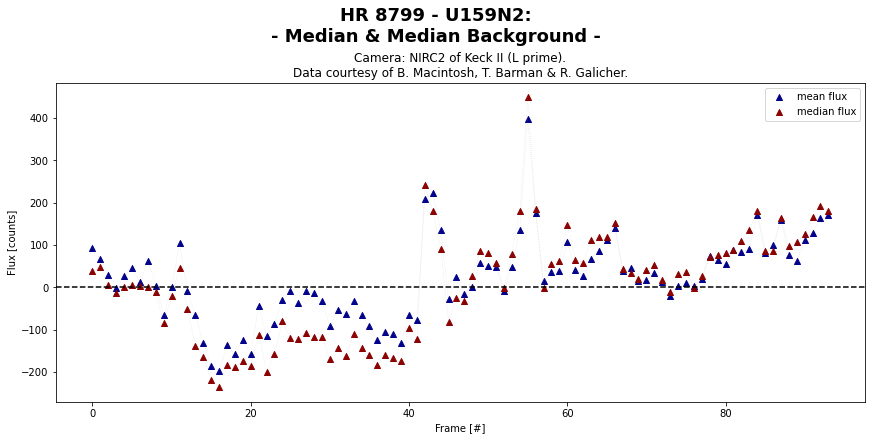

(44920, 94)


In [6]:
# Q4 answer here

Amedsub_mean = np.mean(Amedsub, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

x = np.arange(len(Amedsub_mean))

ax.plot(x, Amedsub_mean, c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(x, Amedsub_mean, c="darkblue", marker="^", label="mean flux")

ax.plot(x, np.median(Amedsub, axis=1), c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(x, np.median(Amedsub, axis=1), c="darkred", marker="^", label="median flux")

ax.axhline(0., c="k", ls="dashed")

ax.set_xlabel(r'Frame [#]')
ax.set_ylabel(r'Flux [counts]')

ax.legend()
ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- Median & Median Background -', fontsize=18, weight="bold")
plt.show()

Ain = np.swapaxes(Amedsub, 0, 1) - Amedsub_mean

print(Ain.shape)

# Q4 end of answer

## Performing the SVD

We now decompose `Ain` into three separate matrices using `np.linalg.svd`, so that:

$$ \texttt{Ain} = \texttt{U} \cdot \texttt{S} \cdot \texttt{V} $$

Where `S` is a diagonal matrix where the diagonal elements are the eigenvalues, `U` contains columns of eigenvectors, and `V` contains rows of eigenvectors.


In [7]:
# this is really cool, Im still amazed - I love linear algebra
# just wished I payed more attention in that course :D
U, s, V = np.linalg.svd(Ain, full_matrices=False, compute_uv=True)
print("Shape of U:       {}".format(U.shape))
print("Shape of s:       {}".format(s.shape))
print("Shape of V:       {}".format(V.shape))

S = np.diag(s)

Shape of U:       (44920, 94)
Shape of s:       (94,)
Shape of V:       (94, 94)


## The size of the eigenvalues


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.5</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Make a `log10` plot of the eigenvalues `s`. Label the x axis 'PCA number' and the y-axis 'log10 eigenvalues'.** 

***

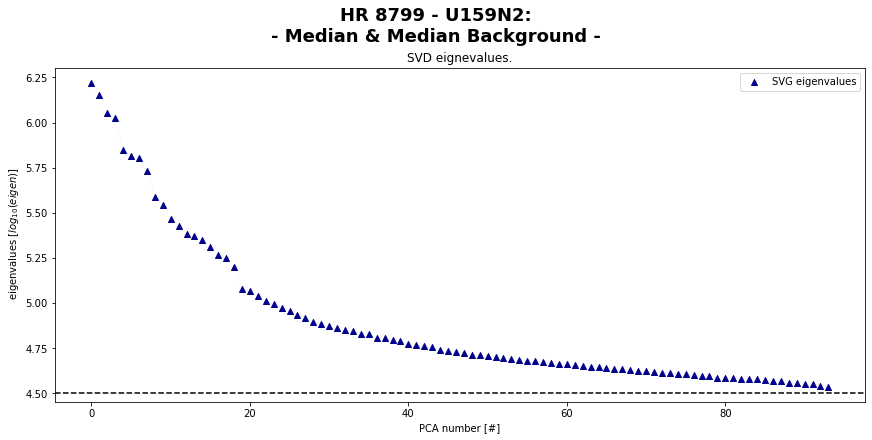

In [8]:
# Q5 answer here

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

x = np.arange(len(s))

ax.plot(x, np.log10(s), c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(x, np.log10(s), c="darkblue", marker="^", label="SVG eigenvalues")


ax.axhline(4.5, c="k", ls="dashed")

# ax.set_yscale("log")

ax.set_xlabel(r'PCA number [#]')
ax.set_ylabel(r' eigenvalues [$log_{10}(eigen)$]')

ax.legend()
ax.set_title('SVD eignevalues.') 
fig.suptitle('HR 8799 - U159N2:\n- Median & Median Background -', fontsize=18, weight="bold")
plt.show()

# Q5 end answer 


 

---
<span style="  font-size:2em; color: SteelBlue;">Question 8.6</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Check that $\texttt{U} \cdot \texttt{S} \cdot \texttt{V} $ is close to `Ain` by using the `np.isclose()` function and printing the fraction of elements that return `True`.**


<div class="alert alert-block alert-info">
<b>Note: </b> Using Numpy the matrix multiplication: $C = A\cdot B$ can be done with: <code>C = np.dot(A,B)</code> </div>

***

99.93 % are within 1.00e-04 relative tolerance.
99.89 % are within 6.16e-05 relative tolerance.
99.82 % are within 3.79e-05 relative tolerance.
99.71 % are within 2.34e-05 relative tolerance.
99.53 % are within 1.44e-05 relative tolerance.
99.24 % are within 8.86e-06 relative tolerance.
98.77 % are within 5.46e-06 relative tolerance.
98.01 % are within 3.36e-06 relative tolerance.
96.76 % are within 2.07e-06 relative tolerance.
94.69 % are within 1.27e-06 relative tolerance.
91.10 % are within 7.85e-07 relative tolerance.
84.27 % are within 4.83e-07 relative tolerance.
70.47 % are within 2.98e-07 relative tolerance.
51.58 % are within 1.83e-07 relative tolerance.
37.50 % are within 1.13e-07 relative tolerance.
19.09 % are within 6.95e-08 relative tolerance.
14.44 % are within 4.28e-08 relative tolerance.
14.44 % are within 2.64e-08 relative tolerance.
14.44 % are within 1.62e-08 relative tolerance.
14.44 % are within 1.00e-08 relative tolerance.


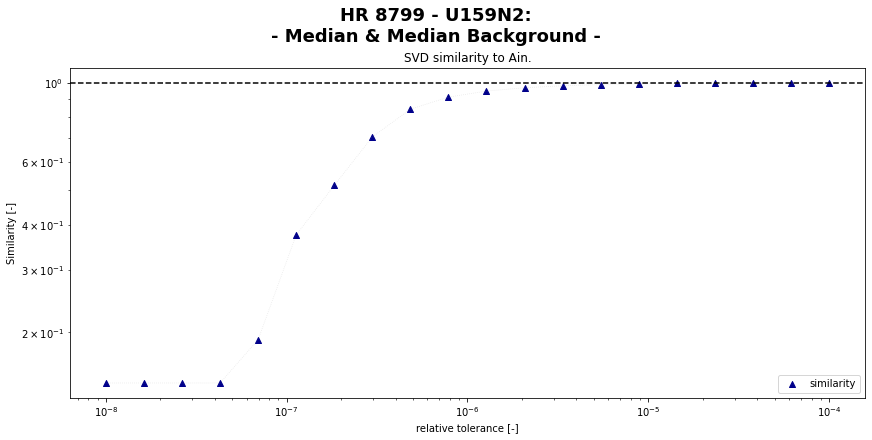

In [9]:
# Q6 answer here

rtols = np.logspace(-4, -8, 20)
closeness = []

for rtol in rtols:
    try:
        C = np.dot(U, S)
        D = np.dot(C, V)
        is_close = np.isclose(Ain, D, rtol=rtol)
        closeness.append(Ain[is_close].size / Ain.size)
        print(f"{Ain[is_close].size / Ain.size * 100.:.2f} % are within {rtol:.2e} relative tolerance.")
    except BaseException:
        print("Uuups, you should not see this.")
        closeness.append(np.nan)
        pass

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(rtols, closeness, c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(rtols, closeness, c="darkblue", marker="^", label="similarity")


ax.axhline(1., c="k", ls="dashed")

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(r'relative tolerance [-]')
ax.set_ylabel(r'Similarity [-]')

ax.legend()
ax.set_title('SVD similarity to Ain.') 
fig.suptitle('HR 8799 - U159N2:\n- Median & Median Background -', fontsize=18, weight="bold")
plt.show()    

# Q6 end answer 

## Approximate the PSF with $k$ numbers of eigenmodes

We can now use all the eigenmodes to *precisely* reconstruct each PSF in the data cube - but of course, that's NOT what we want, because all the images have the planets in them.

Instead, we want to take the first `k` eigenmodes and fit them to each input PSF frame individually. The first `k` modes should not have any planet flux in them, because `k` modes will not be enough to encode a planet moving in an arc through the whole data cube. 

Starting with `k=10`, make `Uk` , `sk` and `Vk` such that you clip out the first `k` columns of `U`, the first `k` values of `s` and the first `k` rows of `V`.


In [10]:
k=10
Uk = U[:,:k]
sk = s[:k]
Vk = V[:k,:]

print("Shape of Uk:       {}".format(Uk.shape))
print("Shape of sk:       {}".format(sk.shape))
print("Shape of Vk:       {}".format(Vk.shape))

Shape of Uk:       (44920, 10)
Shape of sk:       (10,)
Shape of Vk:       (10, 94)


## Reconstructing the PCA PSF and subtracting it

We can now use the first $k$ eigenimages and fit them to each of the individual input images, creating a `reconstructed` image which can then be subtracted off `Ain` to produce the PCA subtracted annuli.

After calculating `residuals` below, put it into an image array called `resid`.

In [11]:
transformed = np.dot(Vk, Ain.T)

reconstructed = np.dot(transformed.T, Vk)

residuals = Ain - reconstructed

resid = np.zeros_like(im)
resid = np.swapaxes(resid,0,-1)

resid[mask] = residuals

wfits(np.swapaxes(resid,0,-1), 'resid.fits')

## Derotating the residuals and stacking together


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.7</span> <span style="  font-size:1em; color: SteelBlue;"> (4 points): </span>

1. **Finally, take the data cube `resid` and derotate to the sky.** 
2.  **Take its median and combine it in a file called `PCAmed`.**
3.  **Display `ADImed` from -400 to 400 and `PCAmed` from -200 to 200 using `ax.imshow()`.** 

***

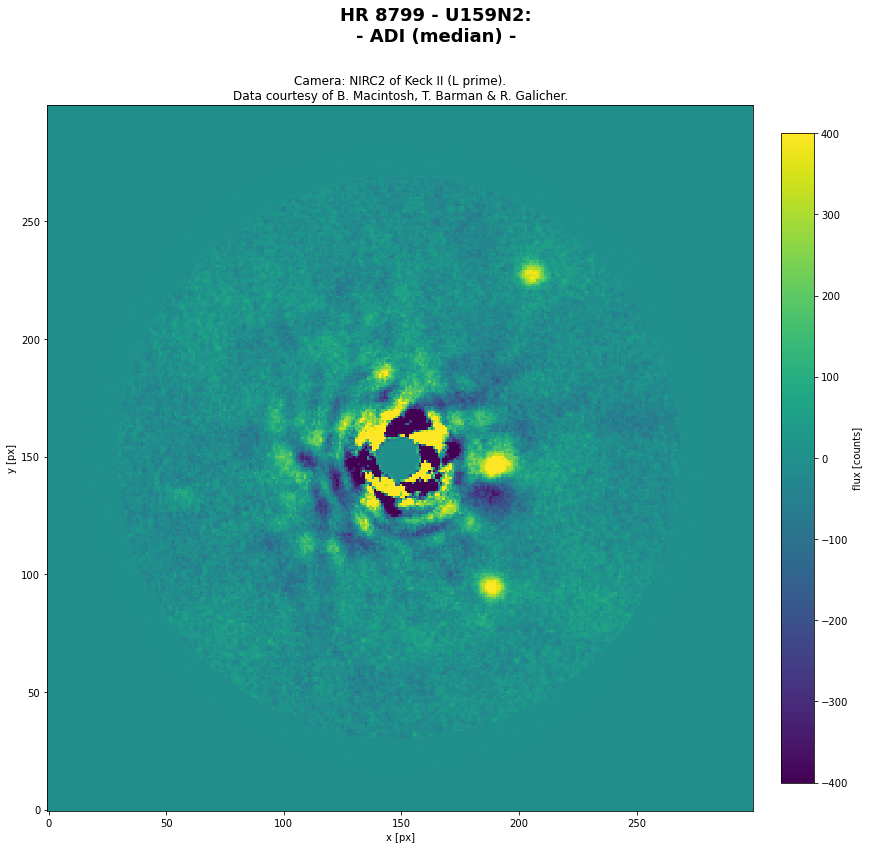

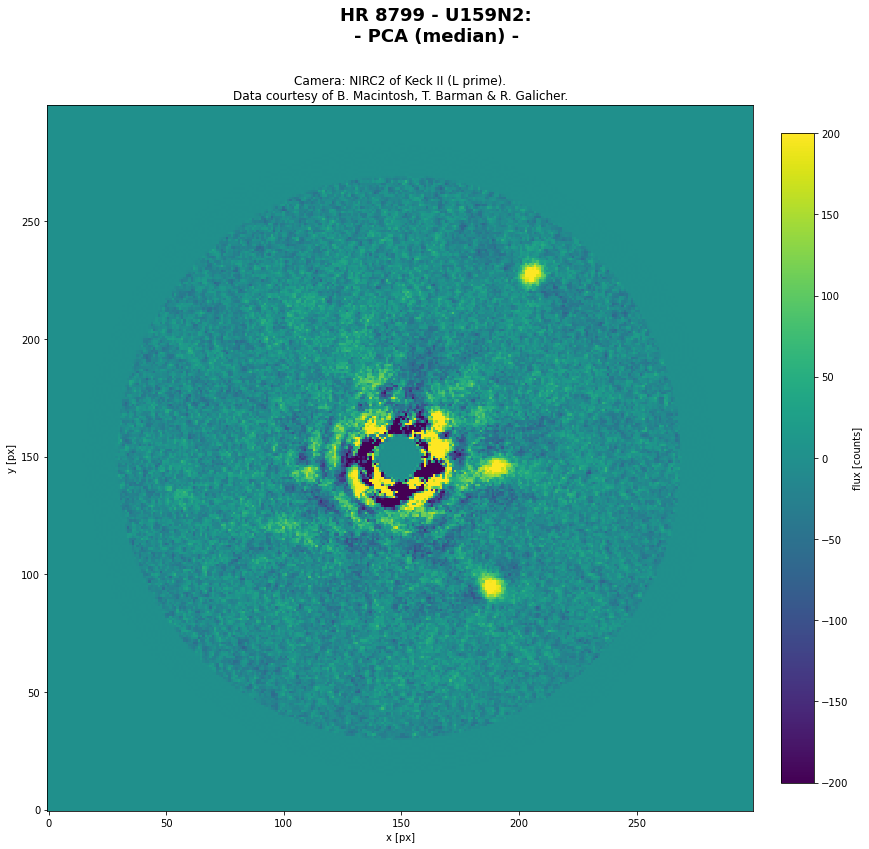

In [12]:
# Q7 answer here

im_resid = np.swapaxes(resid, 0, 2)
resid_derot = derot_cube(im_resid, rot, mask.shape, (xcen, ycen))
PCAmed = np.median(resid_derot, axis = 0)

# ================================================


fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(np.median(ADImed, axis=0),
                    vmax=400., vmin=-400.)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- ADI (median) -', fontsize=18, weight="bold")
plt.show()


# ============


fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(PCAmed,
                    vmax=200., vmin=-200.)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- PCA (median) -', fontsize=18, weight="bold")
plt.show()




# Q7 end answer 

## Comparing median ADI and PCA



---
<span style="  font-size:2em; color: SteelBlue;">Question 8.8</span> <span style="  font-size:1em; color: SteelBlue;"> (4 points): </span>

1. **Define annuli from 0.2 arcsec through to 2.3 arcsec in 0.1 arcsec steps.**
2. **Plot the radius of the middle of width of the ring versus the r.m.s. in each the ring using ADI and for PCA with k = 5, 10, and 20.**
3. **Plot them all on the same graph. Use `ax.set_xlim([0,2.3])` to set the axis limit. Add labels, legend, title, ect.** 

***




C:\Users\lukas\anaconda3\envs\hci\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\lukas\anaconda3\envs\hci\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\lukas\anaconda3\envs\hci\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


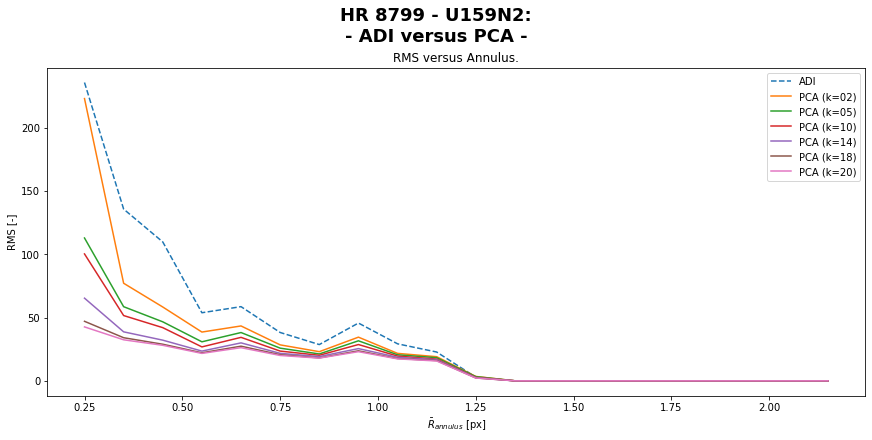

In [13]:
# Q8 answer here

# I dont know why the xaxis lims should be required
# throws a warning but it can be safely ignored

rr, phi = r_theta(im[0], xcen, ycen)
pscale = 0.001 * 10.  # arcsec / px

def get_ring_rms(_img, r_inner, r_outer):
    # make use of generators inside numpy
    rms = np.array([
        np.std(_img[(pscale * rr < r_out) * (pscale * rr > r_in)])
        for r_in, r_out in zip(r_inner, r_outer)
    ])
    return rms


def get_PCA_eigen(k):
    """
    code is the same as above
    """
    _Uk = U[:,:k]
    _sk = s[:k]
    _Vk = V[:k,:]
        
    _transformed = np.dot(_Vk, Ain.T)
    _reconstructed = np.dot(_transformed.T, _Vk)
    _residuals = Ain - _reconstructed
    _resid = np.zeros_like(im)
    _resid = np.swapaxes(_resid, 0, -1)
    _resid[mask] = _residuals
    
    _im_resid = np.swapaxes(_resid, 0, 2)
    _resid_derot = derot_cube(_im_resid, rot, mask.shape, (xcen, ycen))
    return np.median(_resid_derot, axis=0)


annuli = np.arange(0.2, 2.4, 0.1) # to 2.4 because of the stepping
rad_in = annuli[:-1]
rad_out = annuli[1:]
rad_mean = (rad_in + rad_out) / 2.

ks = np.arange(2, 24, 4) # to same where and then set the values that are required
ks[1] = 5
ks[-1] = 20

pcas = np.array([get_PCA_eigen(_k) for _k in ks])
rmss = np.array([get_ring_rms(_pcs, rad_in, rad_out) for _pcs in pcas])
rms_ADI = get_ring_rms(np.median(ADImed, axis = 0), rad_in, rad_out)


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(rad_mean, rms_ADI, ls="dashed", label="ADI")

for lpca, lrms, lk in zip(pcas, rmss, ks):
    ax.plot(rad_mean, lrms, label=f"PCA (k={lk:02.0f})")


ax.set_xlabel(r'$\bar{R}_{annulus}$ [px]')
ax.set_ylabel(r'RMS [-]')

ax.legend()
ax.set_title('RMS versus Annulus.') 
fig.suptitle('HR 8799 - U159N2:\n- ADI versus PCA -', fontsize=18, weight="bold")
plt.show()    


# Q8 end of answer


---
<span style="  font-size:2em; color: SteelBlue;">Question 8.9</span> <span style="  font-size:1em; color: SteelBlue;"> (4 points): </span>

**Measure the total flux from the planet at (x,y) = (188,95) using a 10 pixel diameter aperture for the four images above.** 

**Answer the question: What happens to the planet flux as you go to higher values of $k$?**

***




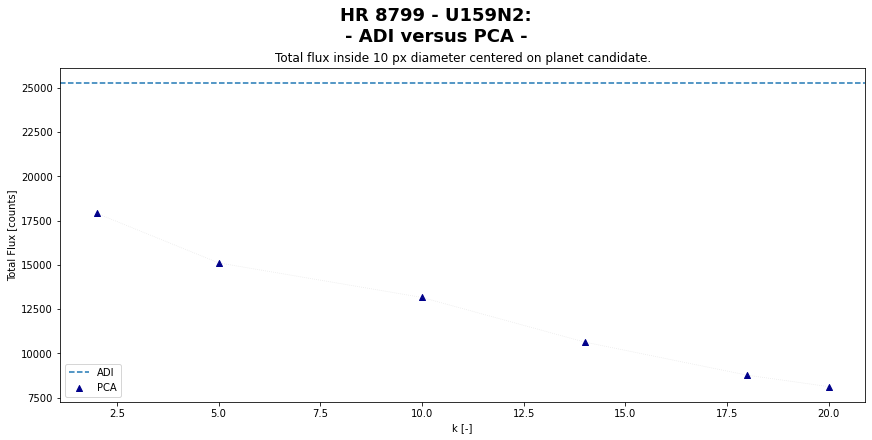

In [14]:
# Q9 answer here

last_rr , theta = r_theta(pcas[0], 188, 95)


fluxes = np.array([
    np.sum(lpca[last_rr <= 5])
    for lpca in pcas
])

ADI_flux = np.sum(np.median(ADImed, axis = 0)[last_rr<=5])


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.axhline(ADI_flux, ls="dashed", label="ADI")

ax.plot(ks, fluxes, c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(ks, fluxes, c="darkblue", marker="^", label="PCA")

ax.set_xlabel(r'k [-]')
ax.set_ylabel(r'Total Flux [counts]')

ax.legend()
ax.set_title('Total flux inside 10 px diameter centered on planet candidate.') 
fig.suptitle('HR 8799 - U159N2:\n- ADI versus PCA -', fontsize=18, weight="bold")
plt.show()    


# Q9 end of answer

The total flux decreases as k increases as the planet is more and more included in the Principal Component Analysis. This is because for large ks the signal from the planet is not much less than the signal from other structures and included in the kth-eigenimage.


<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it! Do <b>NOT</b> send your fits cubes back! Only this Jupyter notebook!</div>

---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


In [15]:
# Number of hours taken for this practicum:
# 3-4
# this is a crazy method